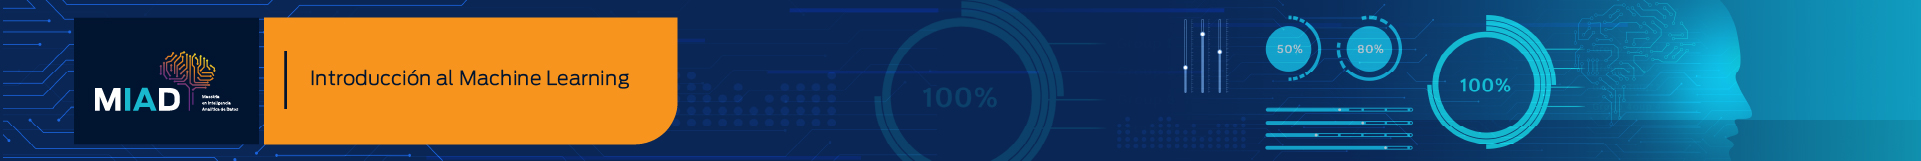

# Introducción al Machine Learning - Semana 4
### Implementación de modelos Aditivos: GAM y MARS

### Propósito de la actividad
En esta actividad mostraremos cómo funciona el principio de la aditividad para hacer frente al problema generado por la maldición de la dimensionalidad. En particular, nos centraremos en los Modelos Generalizados Aditivos (GAM) y en los Modelos Multivariados de Regresión por Splines Adaptativos (MARS). 

### Instrucciones generales

1. En primer lugar, descargue este archivo localmente para poder implementar las librerías que presenta ya que son distintas a las que se han utilizado a lo largo del curso (en particular "pygam" y "pyearth").

2. Para realizar la actividad solo siga las indicaciones asociadas a cada celda del notebook. Sin embargo, siéntase libre de modificar el archivo editando las celdas, lo que le permitirá afianzar su comprensión sobre las distintas funcionalidades de código.  

3. Recuerde que para esta actividad NO necesita realizar ningún tipo de entrega.

### Librerías a importar

A continuación se muestran los comandos a ejecutar para poder implementar los procedimientos de este notebook:


In [1]:
!pip install pygam
!pip install statsmodels

In [2]:
!conda install -c conda-forge sklearn-contrib-py-earth



==> WARNING: A newer version of conda exists. <==
  current version: 4.13.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda





Solving environment: ...working... done

# All requested packages already installed.



In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
from pygam import GAM, s, LinearGAM, te, f, l
from pyearth import Earth

### Carga de datos
Para demostrar el uso de los modelos aditivos, usaremos la famosa base de datos _Boston_, la cual contiene información sobre el precio medio de las viviendas por localidades en Boston, en función de diferentes variables que describen la localidad, como el nivel de crimen($crim$), o la contaminación ($nox$). La variable de respuesta es $medv$, que corresponde a la mediana del precio de las casas en la localidad. Una descripción más detallada de las variables la puede encontrar en: http://lib.stat.cmu.edu/datasets/boston. Para cargar los datos podemos usar:

In [4]:
from sklearn.datasets import load_boston
bostondata=load_boston()
boston=pd.DataFrame(bostondata.data,columns=bostondata.feature_names)
boston['MEDV'] = bostondata.target
boston.head(10)

c:\Users\paulg\anaconda3\envs\nlp_proyect\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California 

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


Es posible inspeccionar la relación de la variable de respuesta con algunas variables predictoras, por ejemplo, la relación con el crimen, muestra una relación natural decreciente y convexa:

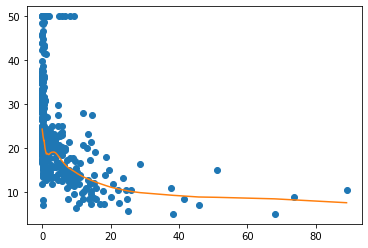

In [5]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess #Funciones de suavización para visualización
smooth = lowess(boston['MEDV'],boston['CRIM'])
plt.plot(boston['CRIM'], boston['MEDV'], 'o') #Visualización de los datos (variable Crimen)
plt.plot(smooth[:,0],smooth[:,1])

O la relación con la contaminación por dióxido de nitrógeno:

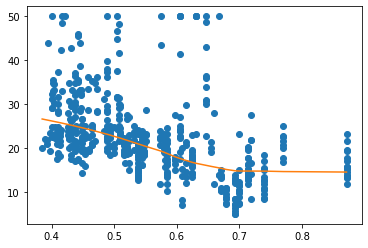

In [6]:
smooth = lowess(boston['MEDV'],boston['NOX'])
plt.plot(boston['NOX'], boston['MEDV'], 'o') #Visualización de los datos (variable NOX)
plt.plot(smooth[:,0],smooth[:,1])

### Implementación de modelo Aditivo Generalizado (GAM)

Como en este caso la variable de respuesta es continua, el modelo de regresión aditivo puede ser formulado como:

$$ Y_i = \beta_0 + f_1(X_{1i}) + f_2(X_{2i}) + \cdots + f_p(X_{pi})  $$

donde $p=13$ en la base de datos de Boston. Es importante notar que la variable $CHAS$ es una variable _dummy_ indicadora de la proximidad al río Charles. Para esta variable no se usa una función suave, sino que en estre caso: $f_4(X_4)=\beta_4X_4$. Para el resto de predictores continuos, cada una de las funciones $f_j$ se puede modelar como una suavizador local (como por ejemplo _regression splines_).

Para implementar el modelo, empezamos separando las variables predictivas de la respuesta:

In [7]:
X=pd.DataFrame(bostondata.data,columns=bostondata.feature_names)
Y=pd.DataFrame(bostondata.target,columns=['MEDV'])
Y 

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2
...,...
501,22.4
502,20.6
503,23.9
504,22.0


Ahora podemos ajustar el modelo. Para regresión con variable de respuesta continua se usa _LinearGAM_:

In [8]:
gam=LinearGAM().fit(X=X, y=Y)  #Esimación modelo GAM para regresión sin calibrar
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    103.2423
Link Function:                     IdentityLink Log Likelihood:                                 -1589.7653
Number of Samples:                          506 AIC:                                             3388.0152
                                                AICc:                                            3442.7649
                                                GCV:                                               13.7683
                                                Scale:                                              8.8269
                                                Pseudo R-Squared:                                   0.9168
Feature Function                  Lam

C:\Users\paulg\AppData\Local\Temp\ipykernel_27068\1534761957.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


En este caso se usaron los parámetros que se tienen por defecto. Por ejemplo, para todas las variables (excepto el intercepto) se modelan las funciones $f_j(X_j)$ como $s()$, lo cual significa que cada una de estas márgenes corresponde a un modelo de _smoothing splines_ con parámetro lambda ($\lambda$) de 0.6 para cada una. Esto genera los grados de libertad efectivos correspondientes (EDoF), los cuales miden el grado de flexibilidad de cada función. Igual que en los modelos de regresión lineal, se tienen _p-values_ relacionados con las significancias de cada una de las variables. 

Para modelar otro tipo de funciones en cada margen, se pueden usar, además de $s()$, $l()$ para cuando se quiere dejar el término lineal ($\beta_j*X_j$) o $f()$ para cuando una variable es un factor. Por ejemplo, podemos usar:

In [9]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [10]:
gam=LinearGAM(terms=s(0)+l(1)+s(2)+l(3)+s(4)+s(5)+s(6)+s(7)+s(8)+s(9)+s(10)+s(11)+s(12)).fit(X=X, y=Y)  #Modelo GAM seleccionado términos
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     97.4058
Link Function:                     IdentityLink Log Likelihood:                                 -1597.9924
Number of Samples:                          506 AIC:                                             3392.7965
                                                AICc:                                            3440.9138
                                                GCV:                                               13.5772
                                                Scale:                                              8.9724
                                                Pseudo R-Squared:                                   0.9142
Feature Function                  Lam

C:\Users\paulg\AppData\Local\Temp\ipykernel_27068\1246774571.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


Para mirar el resultado del modelo, es posibe graficar cada una de las fuciones $f_j$, con sus respectivos intervalos de confianza:

In [27]:
for i, term in enumerate(gam.terms):
    print(term)

spline_term
linear_term
spline_term
linear_term
spline_term
spline_term
spline_term
spline_term
spline_term
spline_term
spline_term
spline_term
spline_term
intercept_term


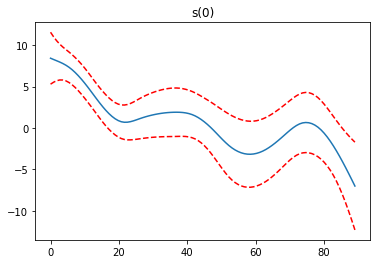

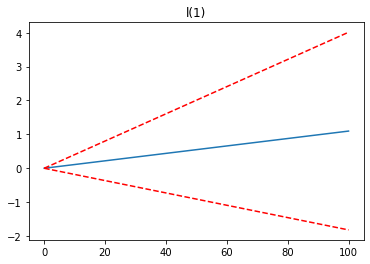

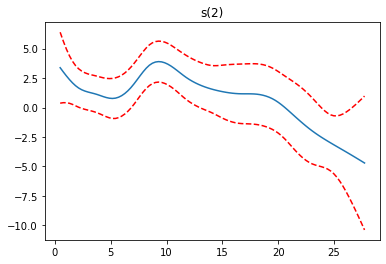

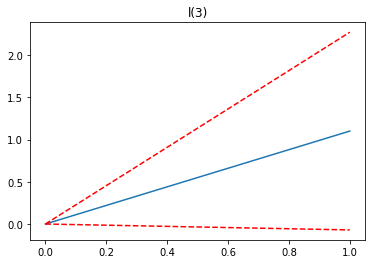

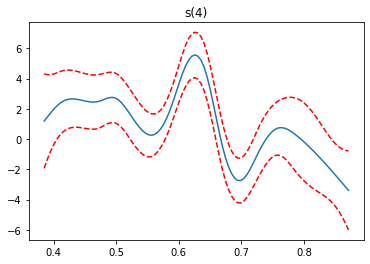

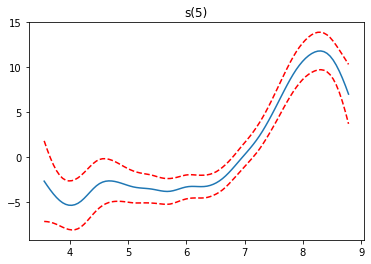

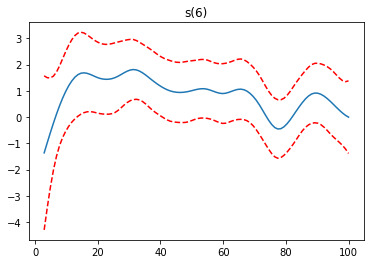

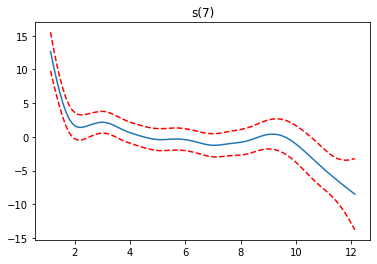

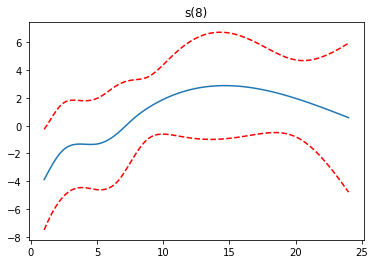

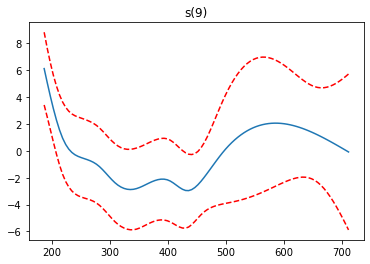

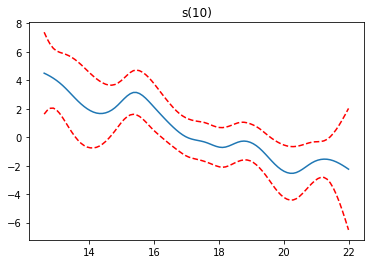

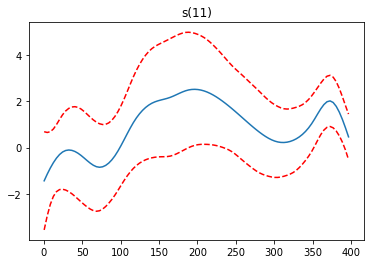

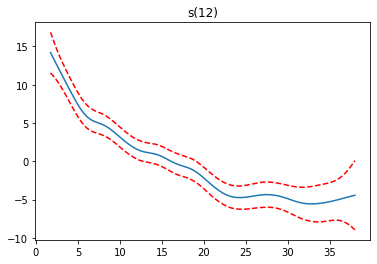

In [11]:
for i, term in enumerate(gam.termsa):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

Es posible ver que algunas de estas funciones no se encuentran bien calibradas. Una de las dificultades del modelo GAM es calibrar todas las estimaciones $f_j$. POr ejemplo, si se prueban 2 valores posibles para $\lambda_j$, se requieren probar $2^{13}$ posibles combinaciones, como se hace en el siguiente código, el cual dejamos a su discresión si lo quiere correr dado que puede tomar un tiempo considerable:

In [12]:
lam = np.array([.2, 1])  #Selección de valores de lambda por variable
lams = [lam] * 13

# La siguiente función calibra el modelo para los prámetros lambda. Se encuentra desactivada.
# gam.gridsearch(X, Y, lam=lams) #Precaución: Puede tomar mucho tiempo

In [13]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     97.4058
Link Function:                     IdentityLink Log Likelihood:                                 -1597.9924
Number of Samples:                          506 AIC:                                             3392.7965
                                                AICc:                                            3440.9138
                                                GCV:                                               13.5772
                                                Scale:                                              8.9724
                                                Pseudo R-Squared:                                   0.9142
Feature Function                  Lam

C:\Users\paulg\AppData\Local\Temp\ipykernel_27068\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


#### Inferencia estadística con modelos GAM:
Existe una forma aproximada de realizar pruebas de hipótesis sobre los términos o la flexibilidad de los modelos. La idea es que en la hipótesis nula se plantea un modelo $M_0$ como el modelo correcto. Este modelo puede tener o no algunas variables y además, algunos términos pueden ser lineales o pueden ser no lineales. En la hipótesis alternativa, se establece un modelo más grande $M_1$, con la característica de que $M_0\in M_1$. Esto es, en $M_0$ se encuentran menos variables, o términos menos flexibles que en el modelo $M_1$:

\begin{eqnarray}
H_0: M_0\;\; \rm{es\; correcto}\\
H_1: M_1\;\; \rm{es\; correcto}
\end{eqnarray}

Por ejemplo, es posible probar si el efecto del crimen es lineal y si las variables _AGE_, _TAX_ y _LSTAT_ pueden ser eliminadas del modelo. En este caso, el modelo $M_0$ puede ser esfecificado como:

In [14]:
gam=LinearGAM(terms=s(0)+l(1)+s(2)+l(3)+s(4)+s(5)+s(6)+s(7)+s(8)+s(9)+s(10)+s(11)+s(12)).fit(X=X, y=Y)  #Modelo GAM seleccionado términos
gam.summary()
gam2=LinearGAM(terms=l(0)+l(1)+s(2)+l(3)+s(4)+s(5)+s(7)+s(8)+s(10)+s(11)).fit(X=X, y=Y)  #Modelo gam reducido
# gam2.summary()

El estadístico de prueba se calcula como:
$$ EP = Deviance(M_0) - Deviance(M_1) $$

El cual tiene una distribución aproximada chi-cuadrado ($\chi^2$) con grados de libertad calculados como la diferencia entre los grados de libertad efectivos de los dos modelos:

$$ g = EDoF(M_1) - EDoF(M_0) $$

Se rechaza $H_0$ en favor de $H_1$ cuando el estadístico de prueba es grande. En particular, para un nivel de significancia $\alpha$, se rechaza cuando:

$$ EP > \chi^2(1-\alpha,gl) $$

Así, para el ejemplo se tiene que:


In [15]:
from scipy.stats import chi2

EP=gam2.statistics_['deviance']-gam.statistics_['deviance']  #Cálculo estdístico de prueba
df=gam.statistics_['edof']-gam2.statistics_['edof']  #Cálculo grados de libertad
pvalue=1-chi2.cdf(EP,df)   #Cálculo p-valor
pvalue


0.46665496232163794

Por lo tanto, no hay suficiente evidencia para rechazar $H_0$.


### Modelos Aditivos para predecir

Para evaluar el modelo, primero se divide la muestra entre _train_ y _test_:

In [16]:
index_test=np.arange(0,len(Y),4)   #Indices para test
index_train=np.delete(np.arange(0,len(Y),1),index_test)   #Índices para train

X_test=X.loc[index_test]
Y_test=Y.iloc[index_test]

X_train=X.loc[index_train]
Y_train=Y.iloc[index_train]


Ahora se estima el modelo GAM en la muestra de _train_:

In [17]:
gam_train=LinearGAM(terms=s(0)+s(1)+s(2)+l(3)+s(4)+s(5)+s(6)+s(7)+s(8)+s(9)+s(10)+s(11)+s(12)).fit(X=X_train, y=Y_train)
gam_train.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     97.8331
Link Function:                     IdentityLink Log Likelihood:                                 -1143.2589
Number of Samples:                          379 AIC:                                             2484.1839
                                                AICc:                                            2554.8714
                                                GCV:                                               14.1278
                                                Scale:                                              7.7665
                                                Pseudo R-Squared:                                   0.9308
Feature Function                  Lam

C:\Users\paulg\AppData\Local\Temp\ipykernel_27068\1510152655.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_train.summary()


Luego,se predice sobre la muestra de _test_ para evaluar el desempeño del modelo usando el $MSE$:

In [18]:
pred=gam_train.predict(X=X_test)  #Predicción en test
mse_test=np.mean((pred-Y_test['MEDV'].values)**2)  #MSE en test
mse_test

22.30298895208909

La relación entre los datos de respuesta en _test_ y las predicciones se puede observar en la siguiente gráfica:

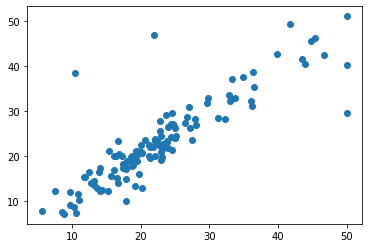

In [19]:
plt.plot(Y_test['MEDV'].values, pred,'o')

### Implementación Multivariate Adaptive Regression Splines (MARS)
Los modelos _MARS_ implementan funciones tipo _linear regression splines_ en cada una de las variables, con particiones en las mediciones $x_{ji}$. Por ejemplo, si se tienen 2 variables $X_1$ y $X_2$, en donde $c_1$ y $c_2$ son las particiones en cada una de las variables, entonces el modelo se pude expresar como:

$$ Y = \beta_0 + \beta_1 h(X_1 - c_1) + \beta_2 h(c_1 - X_1) + \beta_3 h(X_2 - c_2) + \beta_4h(c_2-X_2) + \varepsilon $$

donde $h(\cdot)$ es la función _hinge_. En este ejemplo, el espacio de entradas $(X1,X_2)$ es dividido en cuatro partes. Hasta este momento el modelo es aditivo, sin embargo, el modelo _MARS_ hace uso de interacciones entre funciones tipo _hinge_, lo cual permite variaciones en la función estimada que aplican solamente a las celdas. 

Ajustaremos el modelo a los mismos datos de _Boston_ divididos entre _train_ y _test_, para comparar el desempeño predictivo de los modelos.


In [20]:
mars_train = Earth().fit(X_train,Y_train)  #Ajuste modelo MARS
print(mars_train.summary())

Earth Model
--------------------------------------
Basis Function   Pruned  Coefficient  
--------------------------------------
(Intercept)      No      -160.169     
h(LSTAT-6.87)    No      -0.442321    
h(6.87-LSTAT)    No      2.06032      
h(RM-6.431)      No      8.51241      
h(6.431-RM)      Yes     None         
h(DIS-1.3861)    No      38.1097      
h(1.3861-DIS)    Yes     None         
h(CRIM-15.8744)  Yes     None         
h(15.8744-CRIM)  No      0.698577     
PTRATIO          No      -0.727855    
NOX              No      -15.6508     
RAD              No      0.412485     
TAX              No      -0.0115129   
h(DIS-5.7209)    No      -45.5599     
h(5.7209-DIS)    No      46.5302      
h(DIS-1.7455)    No      7.083        
h(1.7455-DIS)    Yes     None         
CHAS             Yes     None         
AGE              Yes     None         
--------------------------------------
MSE: 9.9467, GCV: 11.7977, RSQ: 0.8806, GRSQ: 0.8591


c:\Users\paulg\anaconda3\envs\nlp_proyect\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
c:\Users\paulg\anaconda3\envs\nlp_proyect\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


En el _summary_ del modelo se puden observar los coeficientes de las bases seleccionadas. Es importante notar que _MARS_ usa la estrategia de _prunning_ o de "podar" para ajustar el nivel de flexibilidad. Es por esto que algunos de los coeficientes son eliminados. Para mirar cómo predice, podemos calcular el desemepño en _test_:

In [21]:
pred_mars=mars_train.predict(X_test)   #Predicción en test
mars_test=np.mean((pred_mars-Y_test['MEDV'].values)**2)   #MSE en test
mars_test

18.501241020895595

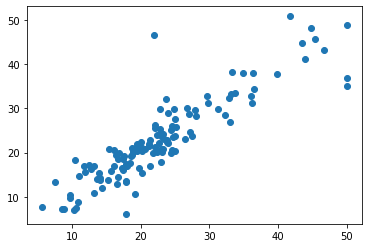

In [22]:
plt.plot(Y_test['MEDV'].values, pred_mars,'o')

In [23]:
X_train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,0.17783,0.0,9.69,0.0,0.585,5.569,73.5,2.3999,6.0,391.0,19.2,395.77,15.10
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
